In [25]:
import audiomentations as A
import librosa
from pathlib import Path
import pandas as pd
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import numpy as np
import noisereduce as nr

In [26]:
# Assume you have a folder of various background noises
noises_path = Path("~/data/kenya_birds/soundscape_data/noise_clips").expanduser()

noises_path.exists()

True

In [27]:
shift = A.Shift(min_shift=-0.5, max_shift=0.5, shift_unit='fraction', p=1.0)

pitch_shift = A.PitchShift(min_semitones=-3, max_semitones=3, p=1.0)

time_stretch = A.TimeStretch(min_rate=0.8, max_rate=1.25, p=1.0)

gain = A.Gain(min_gain_db=-12, max_gain_db=12, p=1.0)

pink_noise = A.AddColorNoise(min_snr_db=5.0, max_snr_db=25.0, min_f_decay=-3.01, max_f_decay=-3.01, p=1.0)

brown_noise = A.AddColorNoise(min_snr_db=5.0, max_snr_db=25.0, min_f_decay=-6.02, max_f_decay=-6.02, p=1.0)

In [28]:
annotations_csv = Path("~/data/kenya_birds/annotations.csv").expanduser()
recordings_path = Path("~/data/kenya_birds/soundscape_data/").expanduser()

print("annotations: ", annotations_csv.exists())
print("recordings: ", recordings_path.exists())

annotations:  True
recordings:  True


In [29]:
df = pd.read_csv(annotations_csv)

df.head()

,Filename,Start Time (s),End Time (s),Species eBird Code
0,KEN_001_20211207_153852.flac,67.8,67.8,slcbou1
1,KEN_001_20211207_153852.flac,106.8,106.8,slcbou1
2,KEN_001_20211207_153852.flac,107.5,107.5,hamerk1
3,KEN_001_20211207_153852.flac,118.4,118.4,slcbou1
4,KEN_001_20211207_153852.flac,209.1,209.1,hamerk1


In [30]:
def load_sample(path, center_time, dur=3.0, sr_target=22050):
  return librosa.load(path, sr=sr_target, offset=max(0, center_time - dur/2), duration=dur)

In [31]:
def preprocess(y: np.ndarray, sr: int, 
               noise_prop_decrease: float = 0.9,
               noise_stationary: bool = True,
               pre_emphasis: float = 0.97,
               normalize: bool = True):
	y = nr.reduce_noise(y=y, sr=sr, prop_decrease=noise_prop_decrease, 
											stationary=noise_stationary)
	y = librosa.effects.preemphasis(y, coef=pre_emphasis)
	if normalize:
		y = librosa.util.normalize(y)
	return y

In [32]:
# Example
r = df.sample().iloc[0]
example_file = recordings_path/df['Filename'].mode()[0]
center_time = (r['Start Time (s)'] + r['End Time (s)']) / 2
dur = 3.0  # seconds

# Load slice
y, sr = load_sample(example_file, center_time)

In [33]:
display(Audio(y, rate=sr, autoplay=False))

In [34]:
y_prep = preprocess(y, sr)
display(Audio(y_prep, rate=sr, autoplay=False))

In [35]:
y_shift = shift(samples=y_prep, sample_rate=sr)
display(Audio(y_shift, rate=sr, autoplay=False))

In [36]:
y_pitch = pitch_shift(samples=y_prep, sample_rate=sr)
display(Audio(y_pitch, rate=sr, autoplay=False))

In [37]:
y_stretch = time_stretch(samples=y_prep, sample_rate=sr)
display(Audio(y_stretch, rate=sr, autoplay=False))

In [38]:
y_gain = gain(samples=y_prep, sample_rate=sr)
display(Audio(y_gain, rate=sr, autoplay=False))

In [39]:
y_pink = pink_noise(samples=y_prep, sample_rate=sr)
display(Audio(y_pink, rate=sr, autoplay=False))

In [40]:
y_brown = brown_noise(samples=y_prep, sample_rate=sr)
display(Audio(y_brown, rate=sr, autoplay=False))

In [41]:
time_augment = A.Compose([
    # Add background noise with a 50% probability
    A.OneOf([
        # add noise from dataset
        # A.AddBackgroundNoise(sounds_path=kenya_noises_path, min_snr_in_db=5.0, max_snr_in_db=35.0),
        # add synthetic pink noise (simulates wind/environmental hum)
        A.AddColorNoise(min_snr_db=5.0, max_snr_db=35.0, min_f_decay=-3.01, max_f_decay=-3.01),
        # add synthetic brown noise (simulates heavy rain/rumble)
        A.AddColorNoise(min_snr_db=5.0, max_snr_db=35.0, min_f_decay=-6.02, max_f_decay=-6.02),
    ], p=0.5),

    # Shift the audio left or right with a 50% probability
    A.Shift(min_shift=-0.5, max_shift=0.5, shift_unit='fraction', p=0.5),

    # Adjust the pitch with a 30% probability
    A.PitchShift(min_semitones=-4, max_semitones=4, p=0.3),
    
    # Adjust the speed with a 30% probability
    A.TimeStretch(min_rate=0.8, max_rate=1.25, p=0.3),

    # Adjust the volume with a 50% probability
    A.Gain(min_gain_db=-12, max_gain_db=12, p=0.5),
])

In [42]:
y_aug = time_augment(samples=y_prep, sample_rate=sr)
display(Audio(y_aug, rate=sr, autoplay=False))

In [43]:
def spec_augment(mel_spec_db, freq_mask_width=10, time_mask_width=10):
    """
    Apply frequency and time masking to a mel spectrogram.

    Args:
        mel_spec_db (np.ndarray): Mel spectrogram in db (log scale).
        freq_mask_width (int): Maximum width of frequency masking.
        time_mask_width (int): Maximum width of time masking.

    Returns:
        np.ndarray: Masked mel spectrogram.
    """
    mel_spec_db = mel_spec_db.copy()

    min_db = mel_spec_db.min()

    # Frequency masking
    num_freq_bins = mel_spec_db.shape[0]
    f = np.random.randint(0, freq_mask_width)
    f0 = np.random.randint(0, num_freq_bins - f)
    mel_spec_db[f0:f0+f, :] = min_db

    # Time masking
    num_time_steps = mel_spec_db.shape[1]
    t = np.random.randint(0, time_mask_width)
    t0 = np.random.randint(0, num_time_steps - t)
    mel_spec_db[:, t0:t0+t] = min_db

    return mel_spec_db

In [44]:
def extract_mel_db_spec(y: np.ndarray, sr: int,
						n_fft: int = 2048, hop_length: int = 512,
						n_mels: int = 128, fmin: int = 280,
						fmax: int = 7600):
	mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, 
																			hop_length=hop_length, n_mels=n_mels, 
																			fmin=fmin, fmax=fmax)
	mel_db = librosa.power_to_db(mel, ref=np.max)
	return mel_db, y

In [45]:
mel_db, _ = extract_mel_db_spec(y_prep, sr)

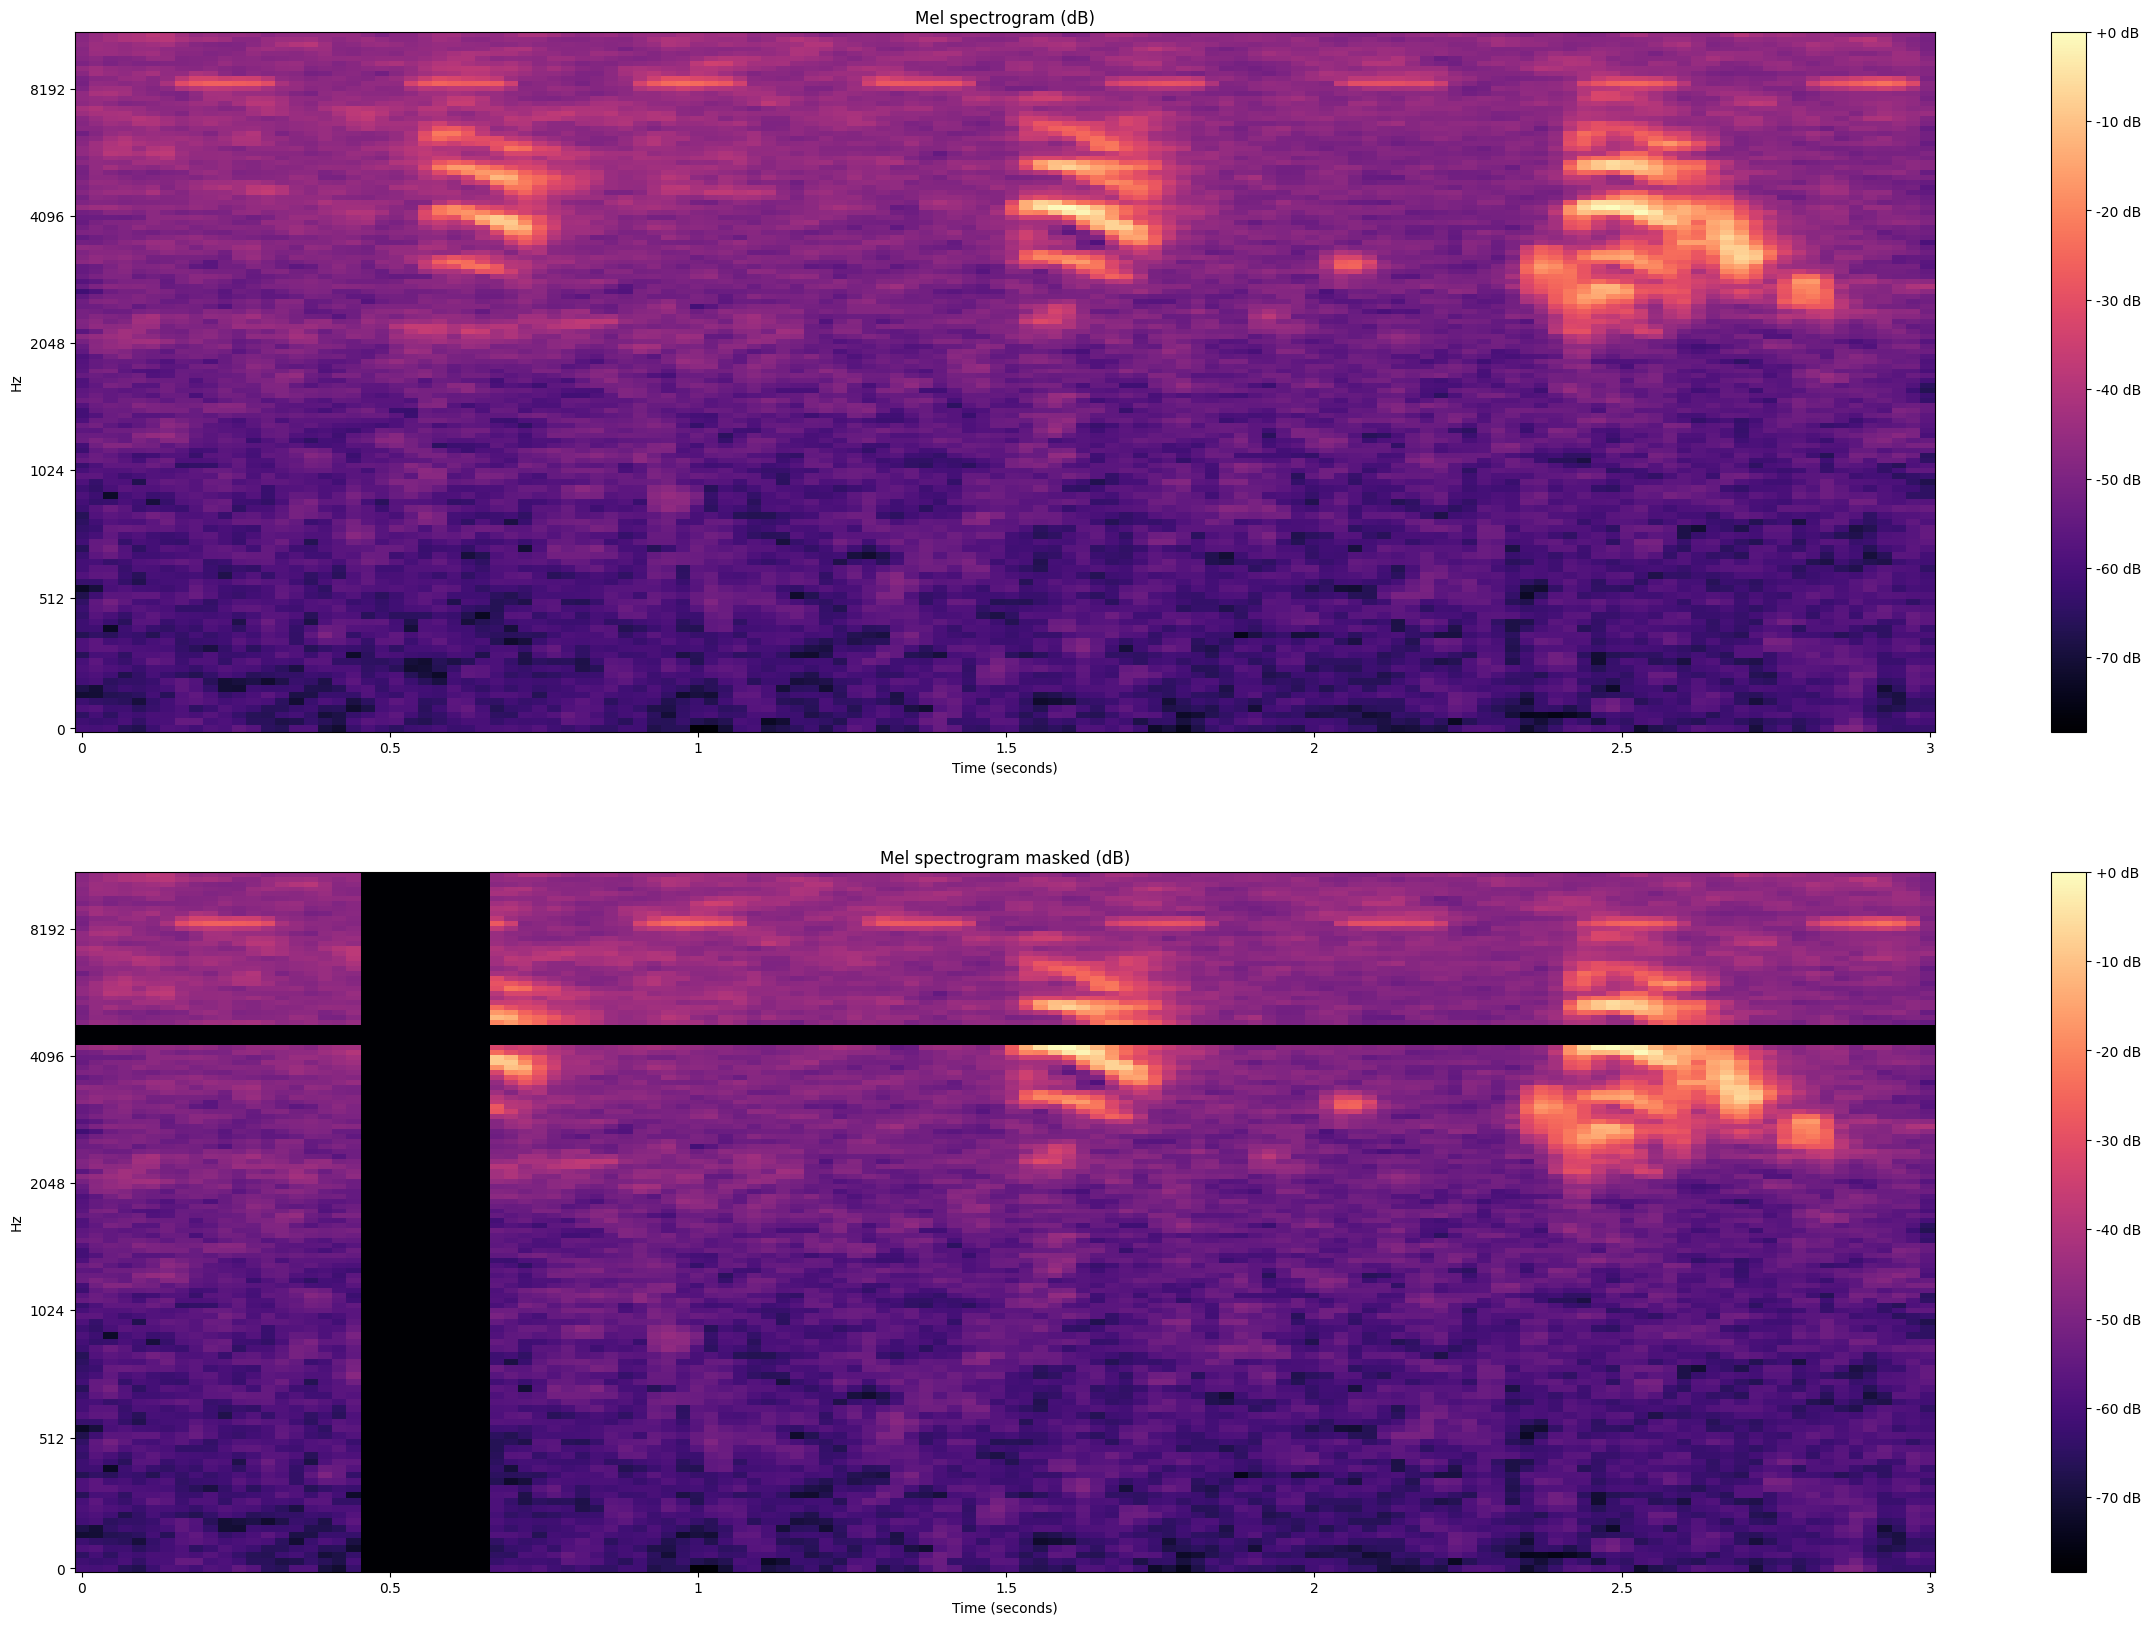

In [46]:
mel_db_aug = spec_augment(mel_db)

plt.figure(figsize=(30,20))
plt.subplot(2,1,1)
librosa.display.specshow(mel_db, sr=sr, x_axis='s', y_axis='mel')
plt.title('Mel spectrogram (dB)')
plt.colorbar(format='%+2.0f dB')

plt.subplot(2,1,2)
librosa.display.specshow(mel_db_aug, sr=sr, x_axis='s', y_axis='mel')
plt.title('Mel spectrogram masked (dB)')
plt.colorbar(format='%+2.0f dB')